In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
import random
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\farra\anaconda3\envs\eeg_env\lib\site-packages\stingray\utils.py:54: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
def calculateFft(data, sample_rate):
    fft = np.fft.fft(data, axis=0)
    fft_freq = np.fft.fftfreq(len(data), d=1.0/sample_rate)
    return np.abs(fft), np.abs(fft_freq)


In [3]:
# def bandpass_filter(data, lowcut, highcut, fs, order=2):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     y = scipy.signal.filtfilt(b, a, data, axis=0)
#     return y

In [4]:
def extract_band_power(fft_values, freq, band, fs):
    band_freq_indices = np.where((freq >= band[0]) & (freq <= band[1]))[0]
    band_power = np.mean(np.abs(fft_values[band_freq_indices, :]) ** 2, axis=0)
    return band_power

In [5]:
def get_dummy(directory):
    names = random.choice(os.listdir(directory))
    files = os.listdir(os.path.join(directory, names))
    # Take random sample file in the folder
    rel_path = os.path.join(directory, names, random.choice(files))
    print(rel_path)
    df_data = pd.read_csv(rel_path)
    return df_data

In [6]:
def fftAnalysis(directory, bands):
    SAMPLING_RATE = 256

    df = get_dummy(directory)
    print(df.values.shape)
    data = df.values

    plt.figure(figsize=(16, 8))
    plt.plot(range(len(data[:, 1])), data)
    plt.xlabel("t")
    plt.ylabel("A")
    plt.title(directory)
    plt.legend(df.columns)
    plt.show()

    fft_result, fft_freq = calculateFft(data, SAMPLING_RATE)

    plt.figure(figsize=(16, 6))
    plt.plot((fft_freq), np.abs(fft_result))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("A")
    plt.title(f"FFT of {directory}")
    plt.legend(df.columns)
    plt.show()

    eeg_band_fft = dict()
    for band in bands:  
        freq_ix = np.where((fft_freq >= bands[band][0]) & 
                        (fft_freq <= bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(np.abs(fft_result[freq_ix] ** 2))

    plot_df = pd.DataFrame(columns=['band', 'val'])
    plot_df['band'] = bands.keys()
    plot_df['val'] = [eeg_band_fft[band] for band in bands]
    ax = plot_df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")

    band_powers = {}
    for band_name, band_range in bands.items():
        band_powers[band_name] = extract_band_power(fft_result, fft_freq, band_range, SAMPLING_RATE)

    band_powers_df = pd.DataFrame(band_powers, index=df.columns)
    band_powers_df = band_powers_df.T
    # Plot stacked bar plot
    plt.figure(figsize=(16,10))
    band_powers_df.plot(kind='bar', stacked=True, figsize=(16,10))
    plt.title('Band Power by Channel')
    plt.xlabel('Channel')
    plt.ylabel('Power')
    plt.legend(title='Band Name')
    plt.show()

    for band_name, power in band_powers.items():
        plt.figure(figsize=(6,6))
        plt.bar(df.columns, power)
        plt.title(f'{band_name.capitalize()} Band Power')
        plt.xlabel('Channel')
        plt.ylabel('Power')
        plt.show()

In [7]:
bands = {'Delta': (.5, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 60)}

SEGMENT_TIME  = 60

## FFT Analysis for Autism Subject

In [8]:
autism_dir = f"datasets/grouped_csv/autism"

datasets/grouped_csv/autism\Nour\Nour_Autism_2_10_2011S001R02.csv
(78832, 16)


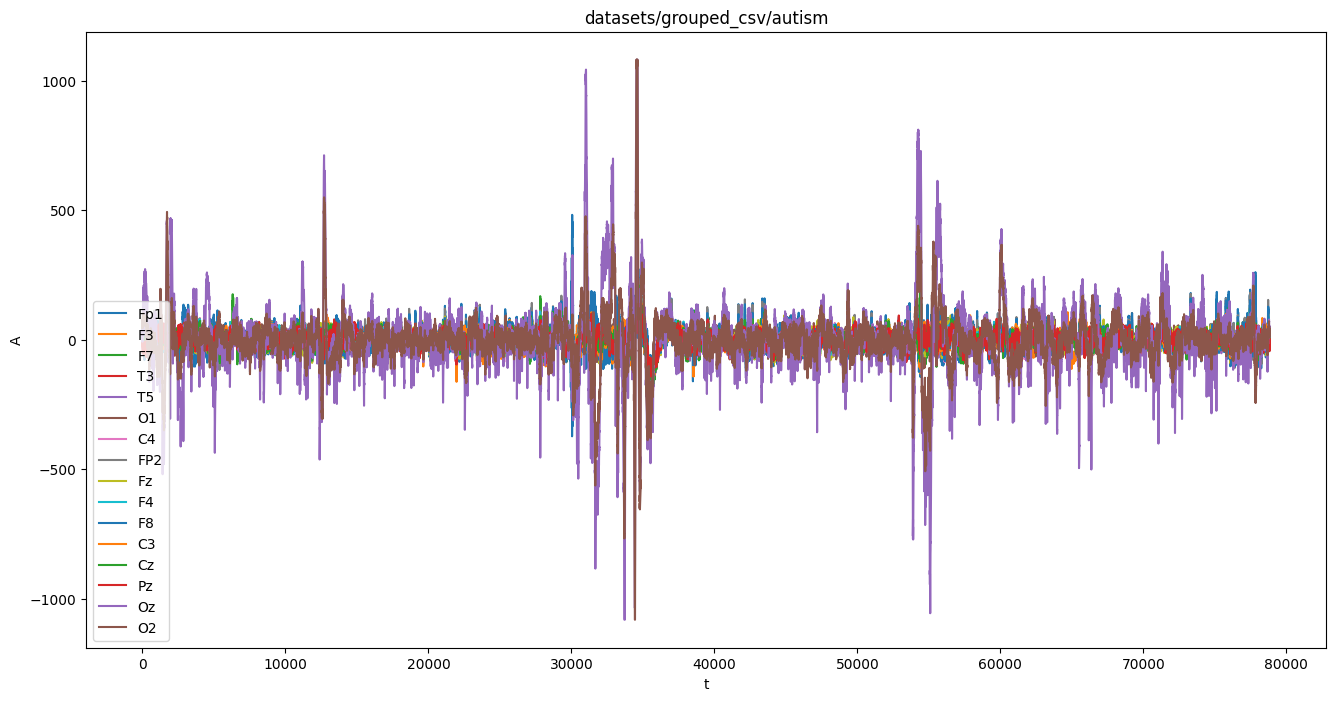

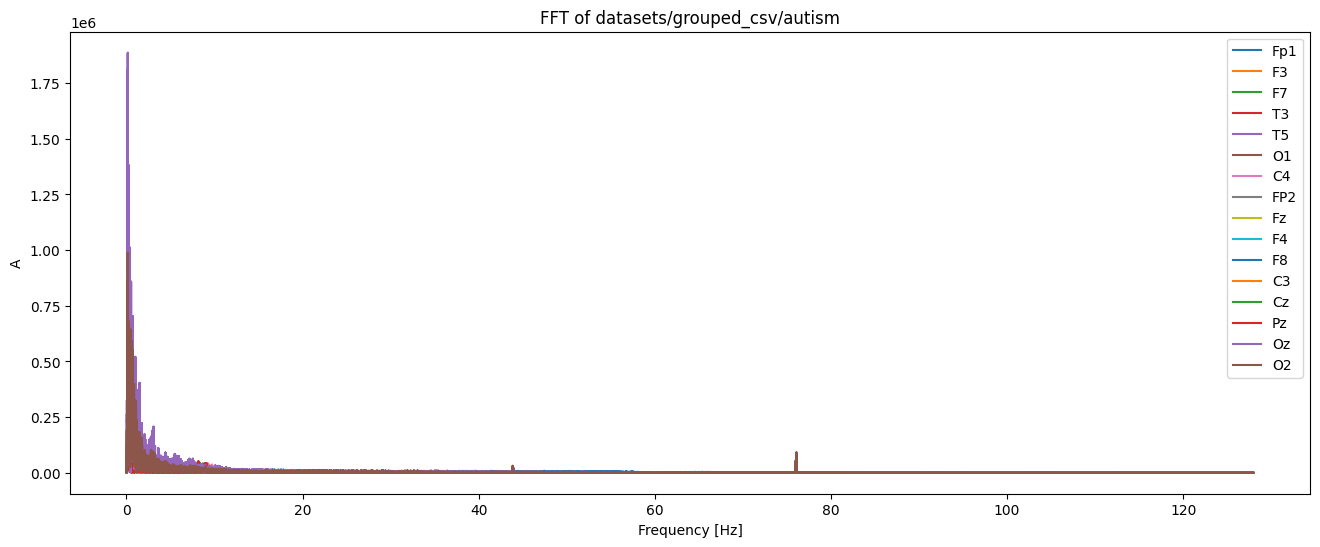

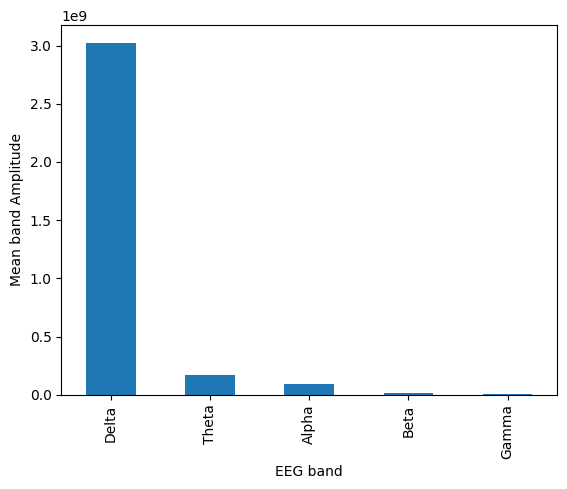

<Figure size 1600x1000 with 0 Axes>

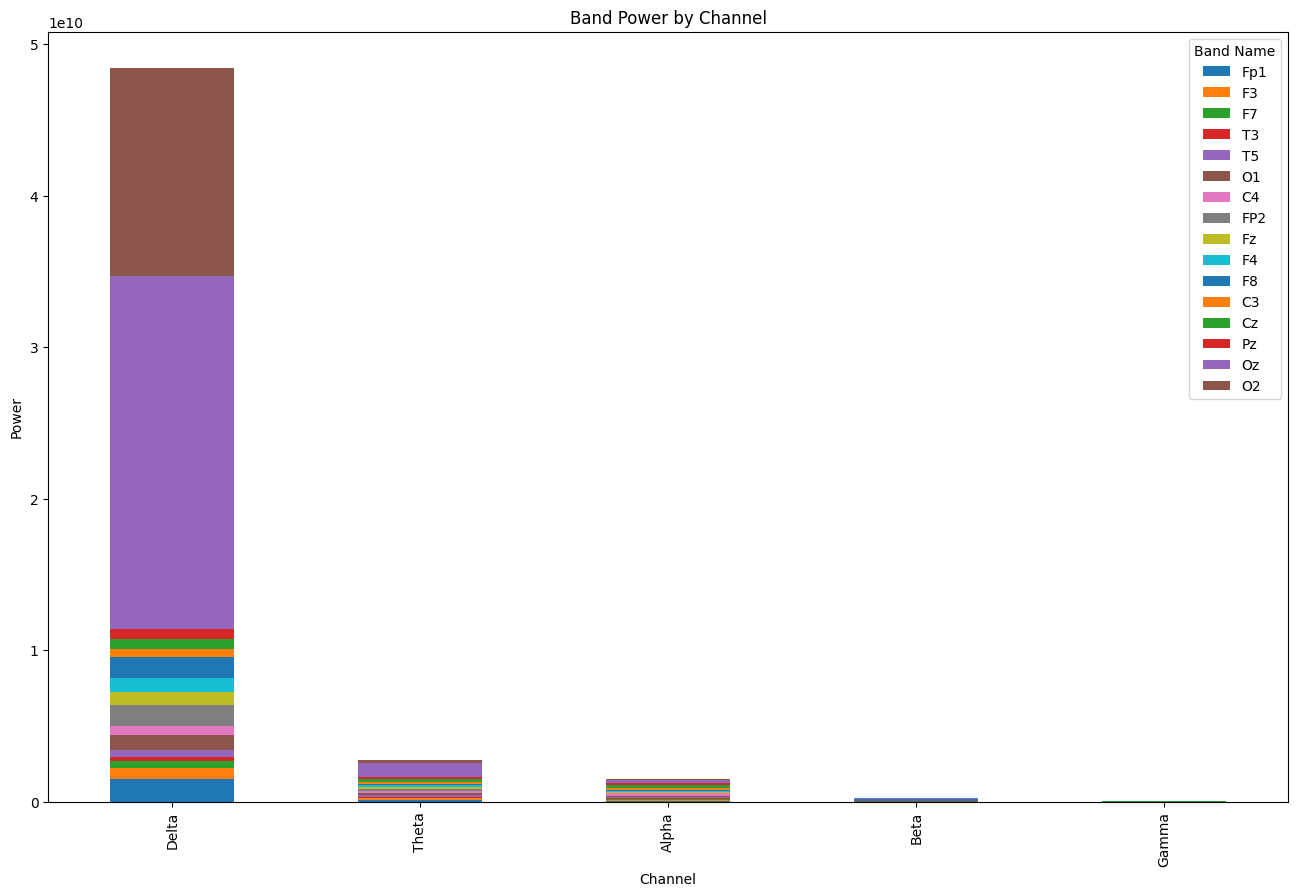

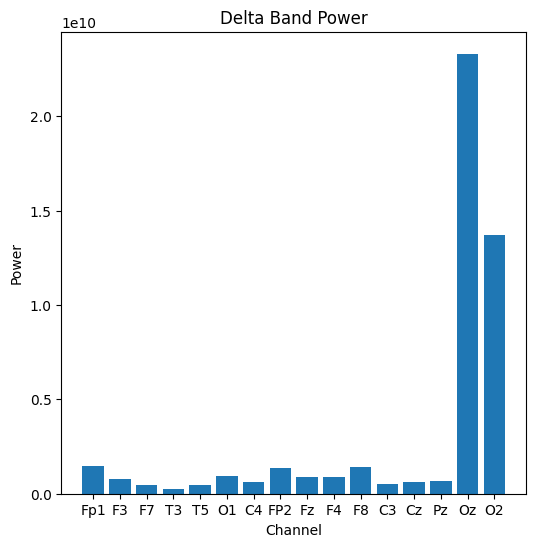

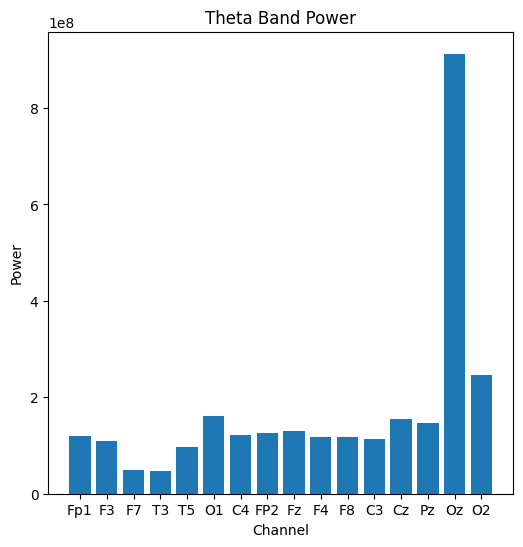

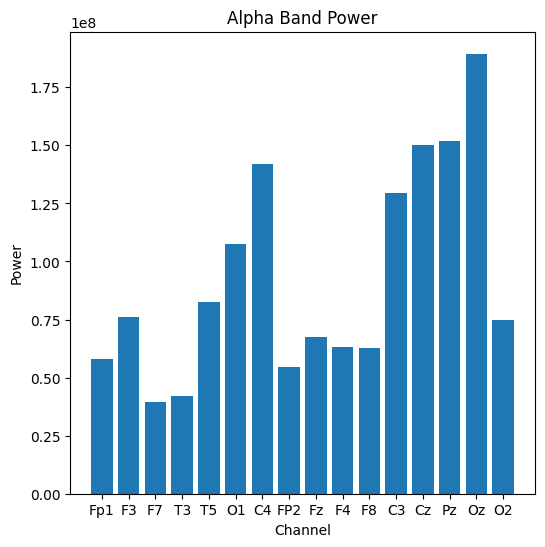

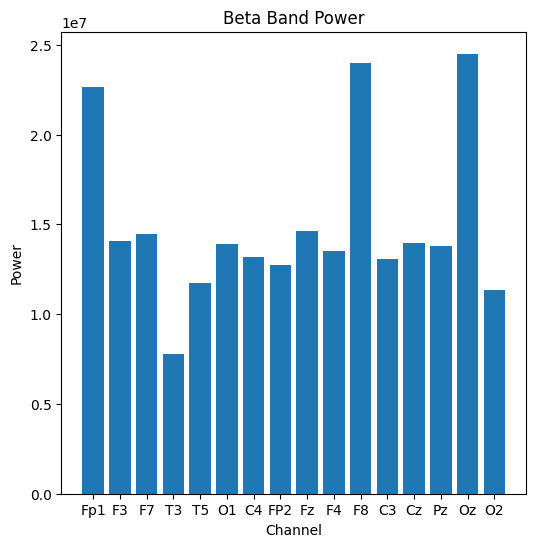

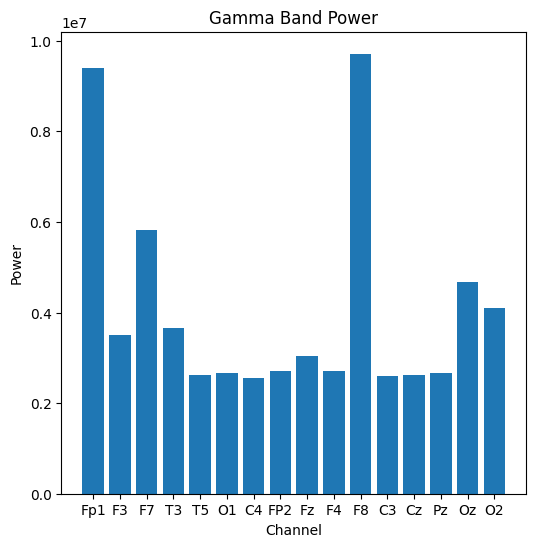

In [9]:
fftAnalysis(autism_dir, bands)

## FFT Analysis for Normal Subject

In [22]:
normal_dir = f"datasets/grouped_csv/normal"

datasets/grouped_csv/normal\Omran\Omran_Normal_5_5_2011S001R01.csv
(231144, 16)


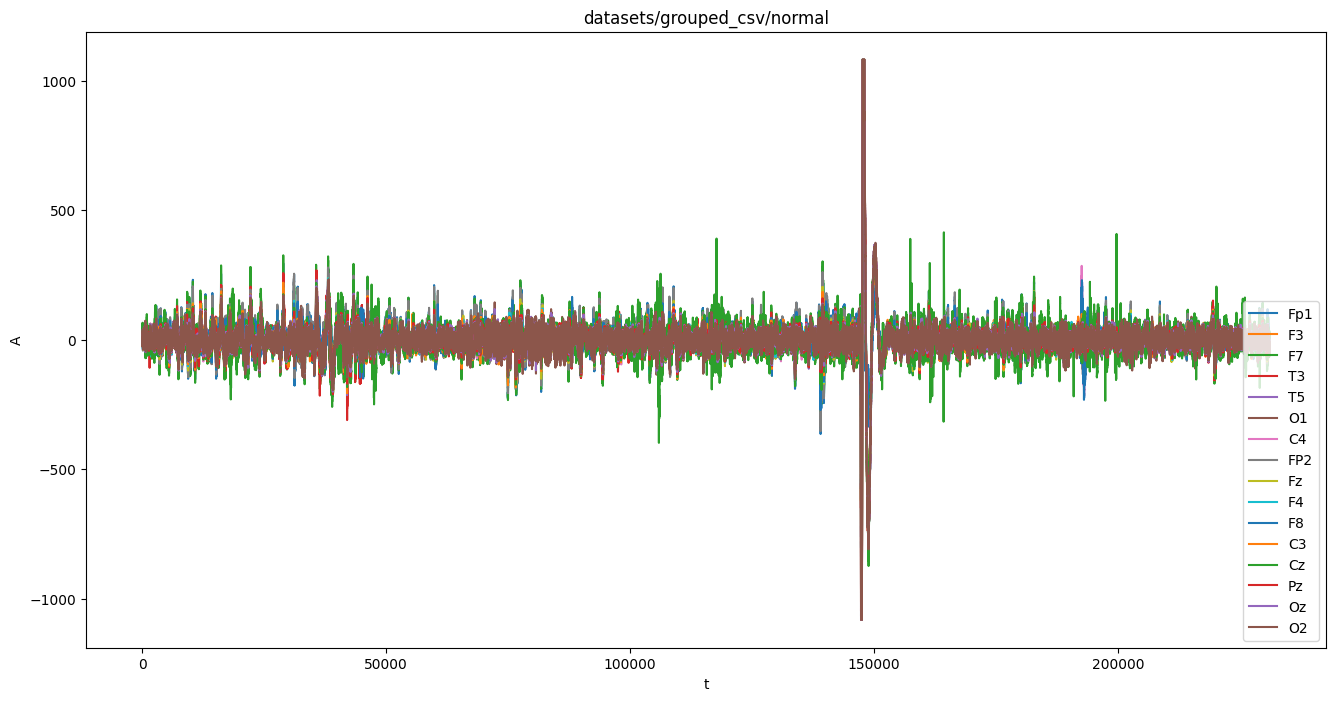

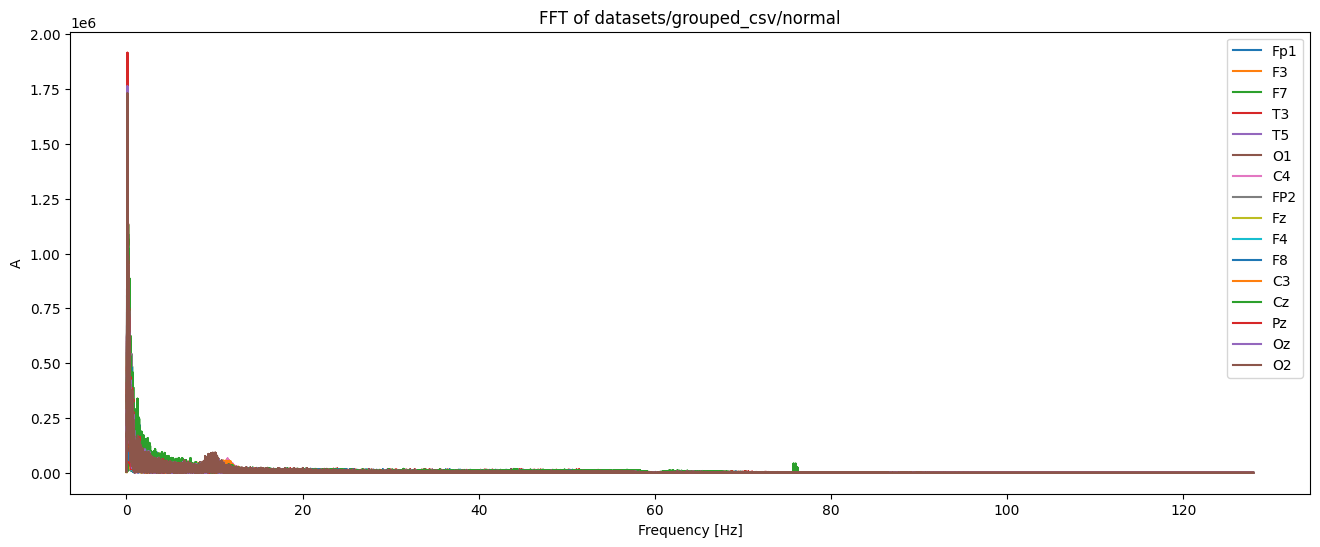

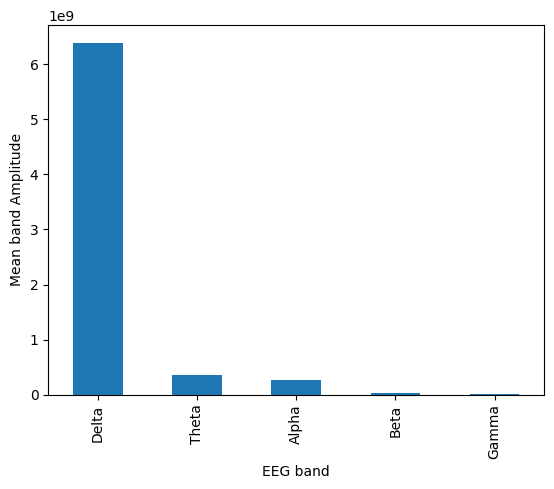

<Figure size 1600x1000 with 0 Axes>

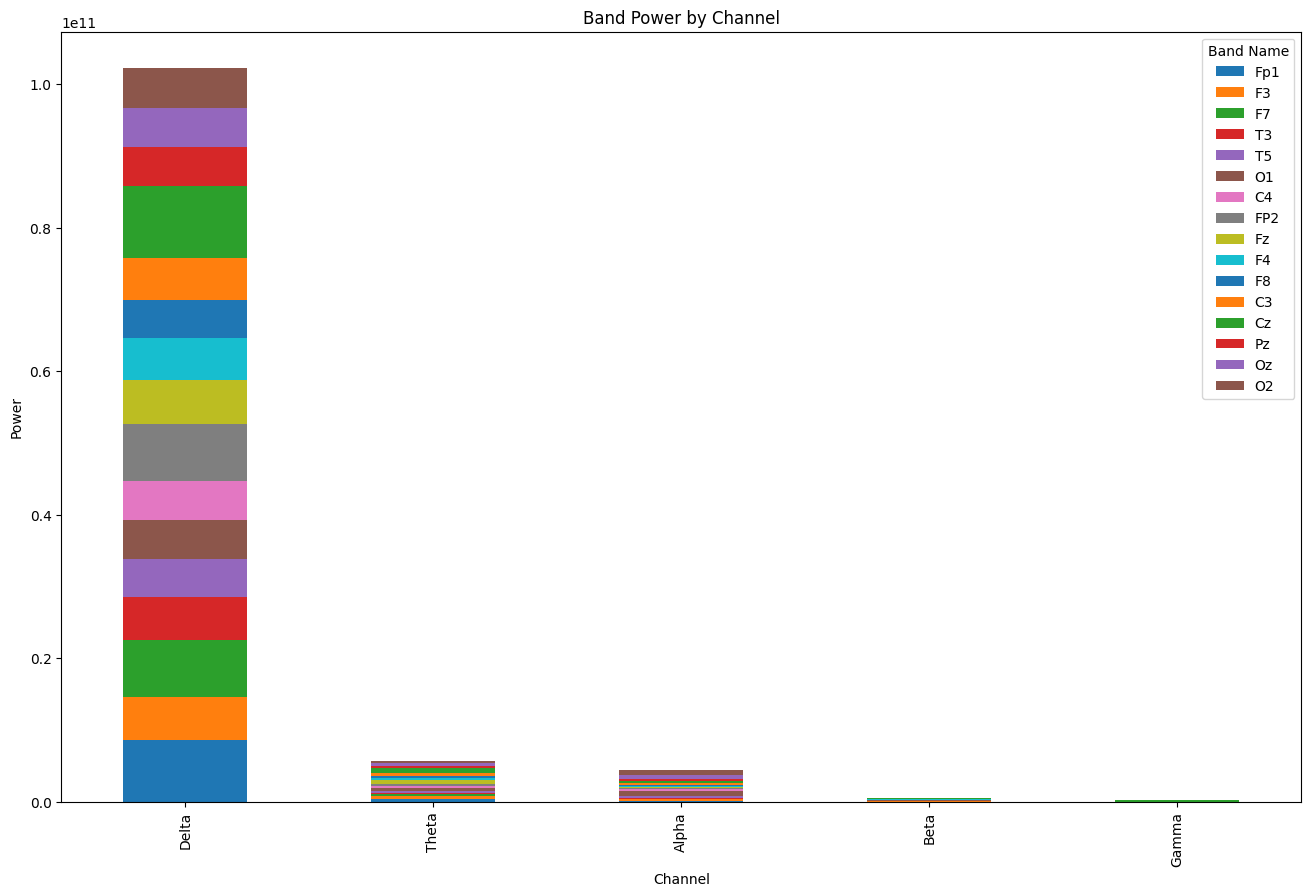

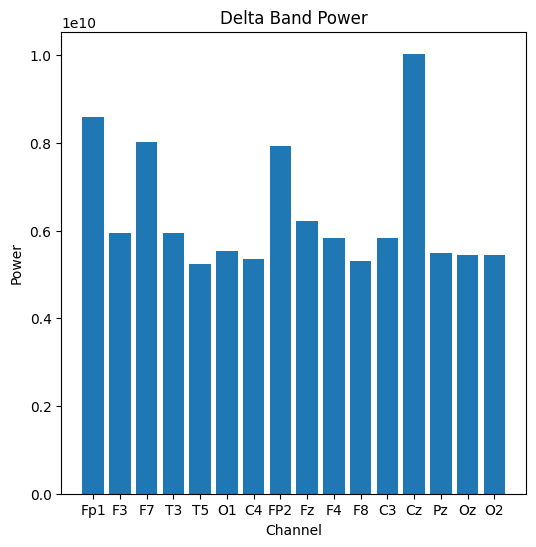

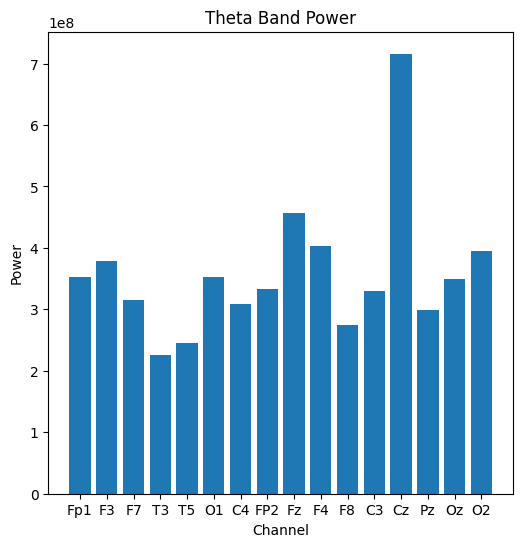

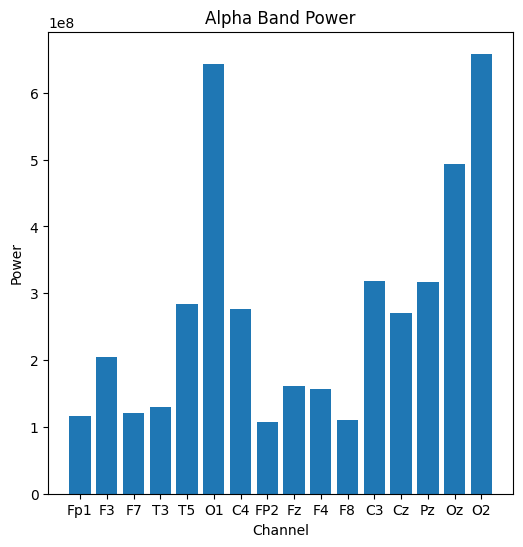

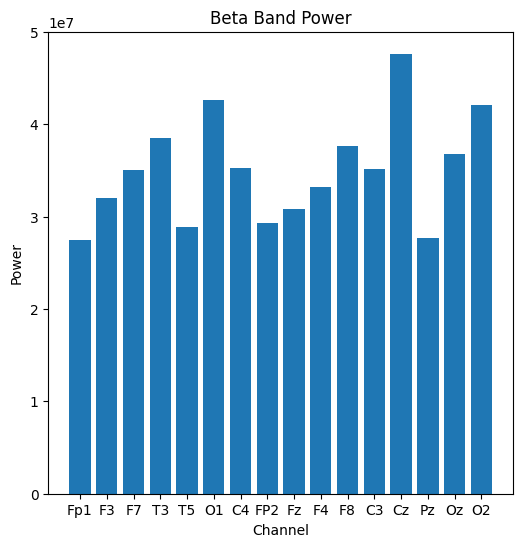

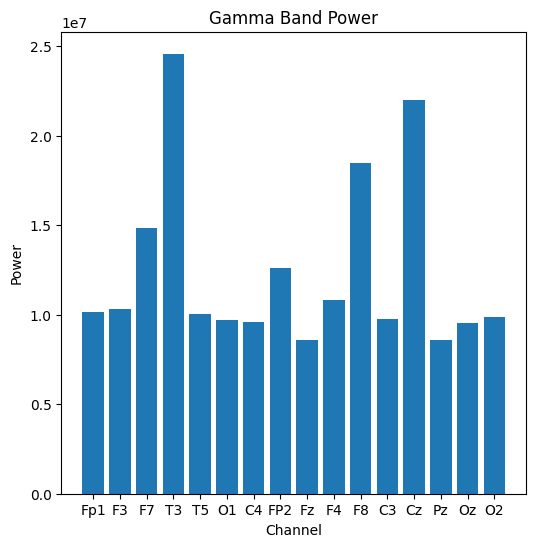

In [27]:
fftAnalysis(normal_dir, bands)

## Bispectrum FFT

In [12]:
def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contour plots
    # plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    # plt.xlabel('f1')
    # plt.ylabel('f2')
    # plt.show()

    # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(bs.freq, bs.freq)
    # ax.plot_surface(X, Y, bs.bispec_mag)
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    return bs

In [13]:
segment_time = 1
fs = 256
t = np.arange(0, 1, 1/(fs * segment_time))

In [14]:
lag = 256
df = get_dummy(f"datasets/segmented_{segment_time} seconds/autism")
data = df.values
channels = df.columns

datasets/segmented_1 seconds/autism\Mohammed\segment_177.csv


In [15]:
# for channel in channels:
#     bs = calcCumulantOrde3(df[channel], t, lag)
bs = calcCumulantOrde3(df['Fp1'], t, lag)

In [16]:
bis_mag = bs.bispec_mag

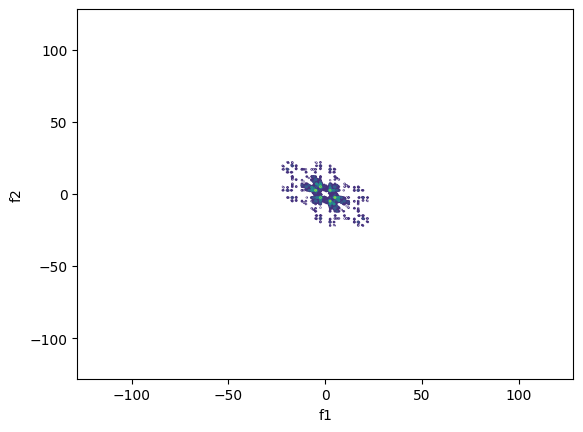

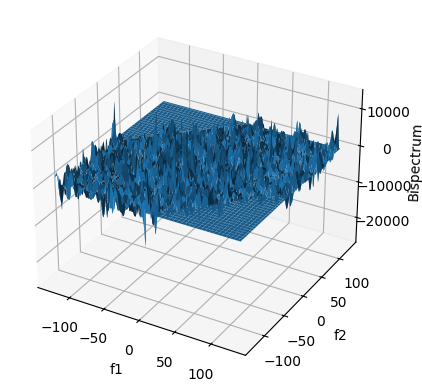

In [17]:
plt.contour(bs.freq, bs.freq, bs.bispec_mag)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(bs.freq, bs.freq)
ax.plot_surface(X, Y, bs.cum3)
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Bispectrum')
plt.show()

In [18]:
df = get_dummy(f"datasets/segmented_{segment_time} seconds/normal")
data = df.values
channels = df.columns

datasets/segmented_1 seconds/normal\Dhelal\segment_745.csv


In [19]:
bs = calcCumulantOrde3(df['Fp1'], t, lag)

In [20]:
bis_mag = bs.bispec_mag

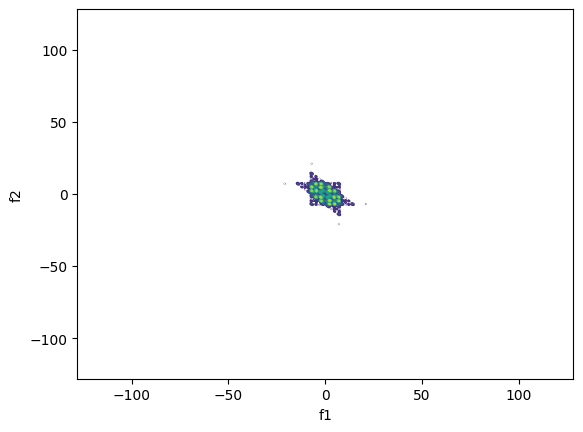

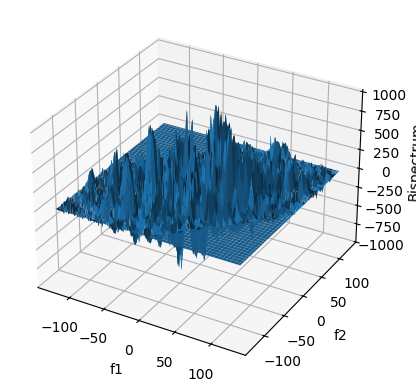

In [21]:
plt.contour(bs.freq, bs.freq, bs.bispec_mag)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(bs.freq, bs.freq)
ax.plot_surface(X, Y, bs.cum3)
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Bispectrum')
plt.show()